# Traitement d'image - TP2
Martin ZERBIB SEBIROT & Kévin LEBORGNE

In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import time

## Exercice 1 — La transformée de Hough pour les cercles
On considère une paramétrisation de type (r, c, rad) pour définir un cercle de rayon rad pixels dans l’image,
dont le centre est situé sur la ligne r et la colonne c. Comme nous sommes obligés de considérer un ensemble
discret de paramètres, on retient toutes les positions r ∈ [rmin, rmax] avec un pas de discrétisation de δr, et
ainsi de suite pour c ∈ [cmin, cmax] avec un pas de discrétisation de δc et pour rad ∈ [radmin, radmax] avec
un pas de discrétisation de δrad.

1- Pour l’image four.png fournie, de taille 100 × 100 pixels, considérons que rmin = 1, rmax = 100,
δr = 2. Combien de valeurs discrètes aura-t-on pour la coordonnée r des cercles ? Et si δr = 0.5 ?


*Réponse : Avec une taille de 100x100, rmin = 1, rmax = 100 et δr = 2, il y a 50 valeurs discètes possible sur la coordonée r des cercles. Avec δr = 0.5, cela passe à 199 valeurs possibles*

2-  Pour la même images, en supposant que rmin = 1, rmax = 100, δr = 1, cmin = 1, cmax = 100, δc = 1,
radmin = 5, radmax = 100√
2, δrad = 1, quel est le nombre total de cercles qu’on peut décrire avec
ces trois variables ?


*Réponse : Il y a 100 valeurs possibles en r, 100 en c et 138 selon rad, ce qui nous donne 100x100x138 = 1 380 000 possibilités*

3- Le tableau tridimensionnel acc associe à la case acc(i, j, k) le cercle situé à la i-ème valeur discrète
de r, la j-ème valeur discrète de c, et la k-ème valeur discrète de rad. Quel est le cercle associé au
acc(1, 1, 1) ? Au acc(10, 7, 30) ?


*Réponse : En supposant que le tableau commence à 1:* 
- *(1, 1, 5)*
- *(10, 7, 35)*

4- Inversement, quelle est la case de l’accumulateur associée au cercle centré dans le pixel (40,40) et de
rayon rad = 13 ? Attention : les indices i,j,k doivent être entiers.


*Réponse : (40, 40, 8)*

## Exercice 2 — Implementation du détecteur

1- On rappelle le fonctionnement de l’algorithme de détection de cercles :
1. (optionnel) Filtrage Gaussien (en cas de bruit ou de détails très fins)
2. Filtrage de Sobel, calcul de la magnitude de gradient Imag dans chaque pixel
3. Tous les pixels dont la magnitude est au dessus d’une fraction t de la valeur maximale dans Imag
sont considérés comme des pixels du contour. Note : visualisez l’image des contours pour être sûrs
que vous avez dedans les contours des objets recherchés.
4. Initialisez toutes les valeurs de l’accumulateur acc à 0.
5. Pour chaque pixel de contour, considérez toutes les (r,c) possibles, calculez le rayon rad pour que
le cercle situé en (r,c) passe par le pixel respectif, et incrémentez dans l’accumulateur la case qui
correspond à (r, c, rad).
2- Identifiez dans l’accumulateur les maximas locaux - les cases avec des valeurs supérieures aux 26 cases voisines (car l’accumulateur est tridimensionnel).
3-  Selectionnez les N valeurs les plus grandes, et à partir des indices (i,j,k) récupérez les (r,c,rad) correspondants et visualisez les cercles en passant par OpenCV.

Note 1 : les cercles plus grands recoivent plus de votes, donc il faudrait normaliser les valeurs de l’accumulateur pour ne pas privil´egier les cercles grands.

Note 2 : pour mettre un vote, on peut incrémenter soit par 1, soit par la magnitude du gradient dans le pixel respectif etc.

Essayez de trouver une solution qui fonctionne pour des images variées (voir par exemple Figure 1 pour des images avec ou sans bruit).

In [1]:
def detectionCercle(img, seuilContours, sensibiliteCercle, color, thickness=1, toGauss=False):
    
    image = cv2.imread(img, cv2.IMREAD_GRAYSCALE)
    if color:
        printImage = cv2.imread(img, cv2.COLOR_BGR2RGB)
        printColor = cv2.COLOR_BGR2RGB
        circleColor = (0, 0, 255)
    else:
        printImage = image
        printColor = cv2.COLOR_GRAY2RGB
        circleColor = (155, 0, 255)
        
    x, y = image.shape

    # Add gaussian blur
    if toGauss:
        gauss = cv2.GaussianBlur(image, (5, 5), 0)
    else:
        gauss = image

    # Sobel filter
    sobelx = cv2.Sobel(gauss, cv2.CV_64F, 1, 0, ksize=5)
    sobely = cv2.Sobel(gauss, cv2.CV_64F, 0, 1, ksize=5)

    # Calculate magnitude
    mag, angle = cv2.cartToPolar(sobelx, sobely, angleInDegrees=True)

    # Definig contours
    contours = np.zeros((x, y))
    for i in range(x):
        for j in range(y):
            if mag[i][j] >= seuilContours:
                contours[i][j] = 1
    # Accumulator
    acc = np.zeros((x, y, int(np.sqrt(x**2 + y**2))))

    for i in range(x):
        for j in range(y):
            if contours[i][j] == 1:
                for r in range(x):
                    for c in range(y):
                        if r != i and c != j:
                            d = np.sqrt((r-i)**2 + (c-j)**2)
                            acc[r][c][int(d)] += 1/(2*np.pi*int(d))
    # Draw circles
    for i in range(x):
        for j in range(y):
            for r in range(int(np.sqrt(x**2 + y**2))):
                if acc[i][j][r] >= sensibiliteCercle:
                    if r >= 5:
                        voisins26 = acc[i-1:i+1, j-1:j+1, r-1:r+1].flatten()
                        if acc[i][j][r] == max(voisins26):
                            printImage = cv2.circle(printImage, (j, i), r, circleColor, thickness)
    plt.axis("off")
    plt.imshow(cv2.cvtColor(printImage, printColor))

    plt.show()

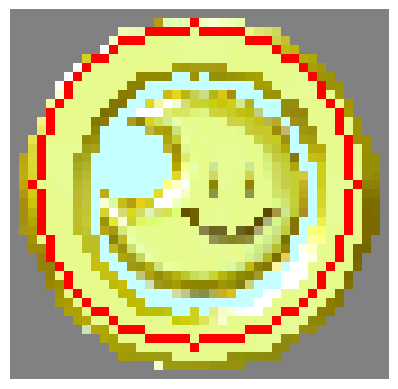

In [7]:
detectionCercle("img/MoonCoin.png", 3500, 0.75, True)

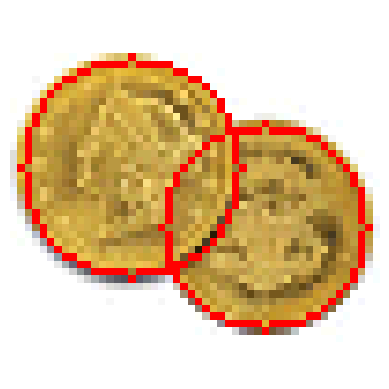

In [4]:
detectionCercle("img/coins.png", 3000, 0.70, True)

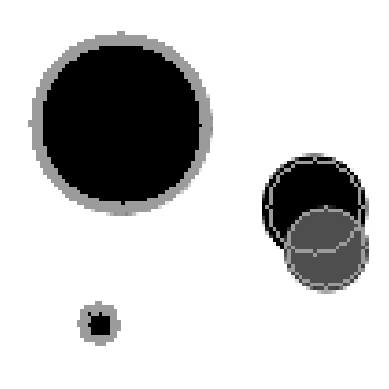

In [68]:
detectionCercle("img/four.png", 3500, 0.75, False)

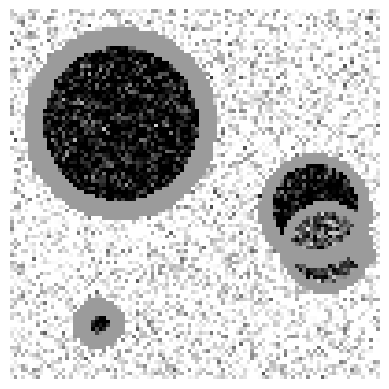

In [64]:
detectionCercle("img/fourn.png", 3500, 0.72, False, 2)

*Pas de difficultées particulières liée à la mise en place de l'algorithme, en dehors de trouver les bon parametres afin de ne pas faire de fausses détections*

## Exercice 3 — Temps de calcul


1- Avec une fonction adaptée (par exemple getTickCount() de OpenCV ou gettimeofday), mesurez le temps de calcul pour four.png. En regardant le code, on peut se rendre compte que la complexité de l’algorithme est de l’ordre de N^4 (pour quoi ?), ou N est la taille en pixels de l’image (100 px). Quel sera le temps de calcul envisagé pour traiter une image avec N proche de 600 px, comme coins2.jpg ?

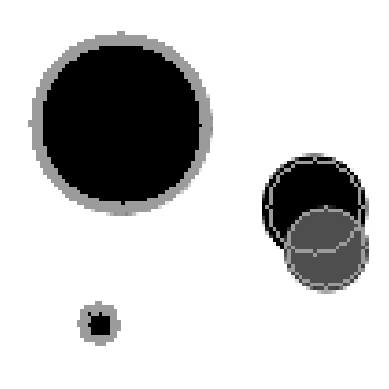

Temps d'exécution : 11.825169563293457 s


In [72]:
start = time.time()
detectionCercle("img/four.png", 3500, 0.75, False)
end = time.time()
print(f"Temps d'exécution : {end - start} s")

*On obtient un temps d'exécution de 21.411 secondes. La complexité de l'algorithme est d'ordre O(N^4) car lors de l'initialisation de l'accumulateur, il y a 4 boucles for imbriquées qui vont de 0 à N-1. Pour un traitement d'une image de coté 600px, cela prendrait environ 7,7 heures*

*Calcul :*

*Sachant que four.png est à N=100*

*C * 100^4 = 21.411 secondes*

*C = 21.411 / 100^4 = 0.00000021411*

*0.00000021411 * 600^4 = 27 748 secondes = 7.7 heures !!!!!*


2- Pour résoudre ce problème de complexité et arriver à traiter des images de taille importante, vous pouvez choisir une des deux solutions suivantes (bonus si vous implémentez les deux) :
1. Calculez à l’aide du filtre de Sobel la direction du gradient, et n’incrémentez dans l’accumulateur les cases que pour les cercles dont le centre se trouve dans la direction du gradient (modulo un petit angle β pour l’incertitude). Dans ce cas, il faudrait essayer d’identifier ces pixels qui se trouvent dans l’image dans la direction du gradient (à l’intérieur d’un cône) de manière très efficace, sans parcourir tous les pixels de l’image.

2. Utilisez une représentation pyramidale de l’image. En supposant que vous réduisez la taille de votre image par 2, vous pouvez faire une détection pour des cercles de rayon [rad1 rad2] et garder les N meilleurs détections. Après vous revenez à la résolution initiale, mais vous n’effectuez une recherche que pour les rayons en [radmin 2 ∗ rad1] parce que le reste a été déjà analysé à la résolution plus faible. Vous pouvez néanmoins affiner la position des N cercles détectés auparavant. Vous pouvez faire cette opération en cascade, à partir d’une résolution très réduite de l’image initiale (4-8 fois).

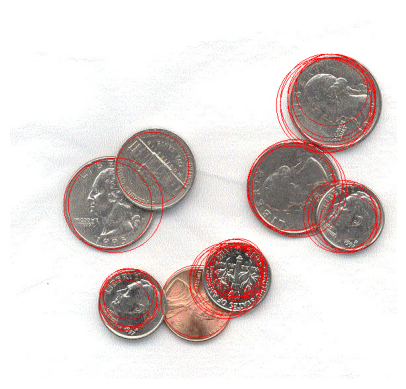

In [53]:
#  non implémenté
def detectionCerclePyramide(img, seuilContours, sensibiliteCercle, color, thickness=1, toGauss=False):
    rezised = False
    image = cv2.imread(img, cv2.IMREAD_GRAYSCALE)
    if color:
        printImage = cv2.imread(img, cv2.COLOR_BGR2RGB)
        printColor = cv2.COLOR_BGR2RGB
        circleColor = (0, 0, 255)
    else:
        printImage = image
        printColor = cv2.COLOR_GRAY2RGB
        circleColor = (155, 0, 255)
    x, y = image.shape
    # si x ou y supérieur à 100, on réduit la taille de l'image de manière à ce que x et y soient inférieurs à 100
    if x > 100 or y > 100:
        rezised = True
        if x > y:
            ox, oy = x, y
            image = cv2.resize(image, (100, int(100*y/x)))
            x, y = image.shape
        else:
            ox, oy = x, y
            image = cv2.resize(image, (int(100*x/y), 100))
            x, y = image.shape
        
    # Add gaussian blur
    if toGauss:
        gauss = cv2.GaussianBlur(image, (5, 5), 0)
    else:
        gauss = image

    # Sobel filter
    sobelx = cv2.Sobel(gauss, cv2.CV_64F, 1, 0, ksize=5)
    sobely = cv2.Sobel(gauss, cv2.CV_64F, 0, 1, ksize=5)

    # Calculate magnitude
    mag, angle = cv2.cartToPolar(sobelx, sobely, angleInDegrees=True)

    # Definig contours
    contours = np.zeros((x, y))
    for i in range(x):
        for j in range(y):
            if mag[i][j] >= seuilContours:
                contours[i][j] = 1
  
    # Accumulator
    acc = np.zeros((x, y, int(np.sqrt(x**2 + y**2))))
    
    for i in range(x):
        for j in range(y):
            if contours[i][j] == 1:
                for r in range(x):
                    for c in range(y):
                        if r != i and c != j:
                            d = np.sqrt((r-i)**2 + (c-j)**2)
                            acc[r][c][int(d)] += 1/(2*np.pi*int(d))
    # Draw circles
    for i in range(x):
        for j in range(y):
            for r in range(int(np.sqrt(x**2 + y**2))):
                if acc[i][j][r] >= sensibiliteCercle:
                    if r >= 7:
                        voisins26 = acc[i-1:i+1, j-1:j+1, r-1:r+1].flatten()
                        if acc[i][j][r] == max(voisins26):
                            if rezised:
                                printImage = cv2.circle(printImage, (int(j*oy/y), int(i*ox/x)), int(r*ox/x), circleColor, thickness)
                            else:
                                printImage = cv2.circle(printImage, (j, i), r, circleColor, thickness)
    plt.axis("off")
    plt.imshow(cv2.cvtColor(printImage, printColor))

    plt.show()
    

detectionCerclePyramide('img/coins2.jpg', 3600, 0.5, True)
